# Create Session Report

In [1]:
%config Completer.use_jedi = False

In [2]:
from pathlib import Path
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

from pynwb import NWBHDF5IO

from spiketools.measures import compute_spike_rate
from spiketools.spatial.occupancy import compute_occupancy

from spiketools.plts.data import plot_bar, plot_hist
from spiketools.plts.space import plot_heatmap
from spiketools.plts.spikes import plot_unit_frs

In [3]:
import seaborn as sns
sns.set_context('talk')

In [4]:
import sys
sys.path.append('../code')
from plts import plot_polar_hist
from reports import *

## Settings

In [5]:
# Define the base data folder
data_folder = Path('/Users/tom/Documents/Data/JacobsLab/TH/')

In [6]:
# Define subject information
task = 'THF'
subj = 'wv004'
session = 0

In [7]:
# Define bins to use
bins = [7, 21]

## Load Data

In [8]:
# Define expected NWB file name & full path
file_name = '_'.join([task, subj, 'session_' + str(session)]) + '.nwb'
full_path = data_folder / 'NWB' / file_name

In [9]:
# Load NWB file
io = NWBHDF5IO(str(full_path), 'r')
nwbfile = io.read()

In [10]:
# Get the subject & session ID from file
subj_id = nwbfile.subject.subject_id
session_id = nwbfile.session_id

## Position Information

In [11]:
# Get position & speed information
pos = nwbfile.acquisition['position']['xy_position']
speed = nwbfile.processing['position_measures']['speed'].data[:]

In [12]:
# Compute occupancy
occ = compute_occupancy(pos.data[:], pos.timestamps[:], bins, speed, set_nan=True)

## Behavioural Information

In [13]:
# Count confidence answers
conf_counts = Counter(nwbfile.trials.confidence.data[:])

In [14]:
# Fix confidence answers
for el in ['yes', 'maybe', 'no']:
    if el not in conf_counts:
        conf_counts[el] = 0

## Unit Information

In [15]:
# Calculate the average overall firing rate of each neuron
n_units = len(nwbfile.units)
frs = [compute_spike_rate(nwbfile.units.get_unit_spike_times(s_ind) / 1000) \
       for s_ind in range(n_units)]

## Create Report

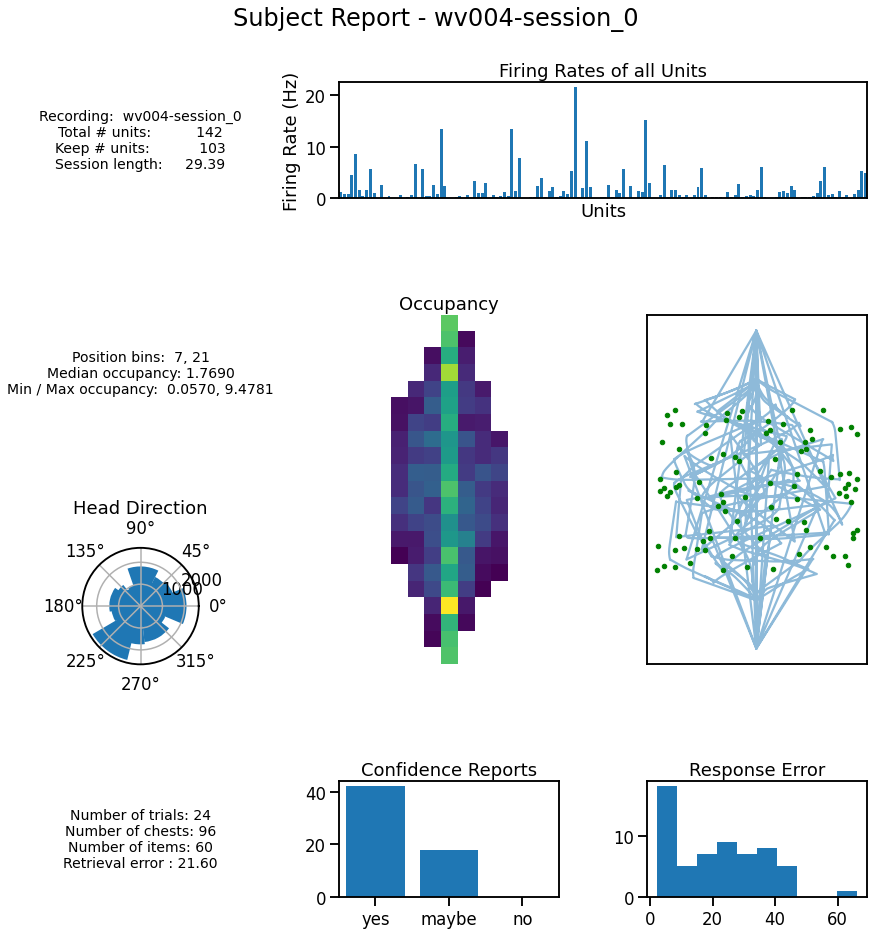

In [16]:
# Initialize figure
_ = plt.figure(figsize=(15, 15))
grid = gridspec.GridSpec(4, 3, wspace=0.4, hspace=1.0)
plt.suptitle('Subject Report - {}'.format(session_id), fontsize=24, y=0.95);

# 00: subject text
ax00 = plt.subplot(grid[0, 0])
subject_text = create_subject_str(create_subject_info(nwbfile))
ax00.text(0.5, 0.5, subject_text, fontdict={'fontsize' : 14}, ha='center', va='center');
ax00.axis('off');

# 01: neuron fig
ax01 = plt.subplot(grid[0, 1:])
plot_unit_frs(frs, ax=ax01)
ax01.set(xticks=[])

# 10: position text
ax10 = plt.subplot(grid[1, 0])
position_text = create_position_str(bins, occ)
ax10.text(0.5, 0.5, position_text, fontdict={'fontsize' : 14}, ha='center', va='center');
ax10.axis('off');

# 11: occupancy map
ax11 = plt.subplot(grid[1:3, 1])
plot_heatmap(occ, transpose=True, title='Occupancy', ax=ax11)

# 12: subject positions overlaid with chest positions
ax12 = plt.subplot(grid[1:3, 2])
ax12.plot(*nwbfile.acquisition['position']['xy_position'].data[:], alpha=0.5)
ax12.plot(*nwbfile.acquisition['chest_positions']['chest_positions'].data[:], '.g');
ax12.set(xticks=[], yticks=[]);

# 20: head direction
ax10 = plt.subplot(grid[2, 0], polar=True)
degrees = nwbfile.acquisition['position']['head_direction'].data[:]
degrees = degrees + -np.min(degrees[degrees < 0])
plot_polar_hist(degrees, ax=ax10)
ax10.set_title('Head Direction')

# 30: behaviour text
ax20 = plt.subplot(grid[3, 0])
behav_text = create_behav_str(create_behav_info(nwbfile))
ax20.text(0.5, 0.5, behav_text, fontdict={'fontsize' : 14}, ha='center', va='center');
ax20.axis('off');

# 31: choice point plot
ax21 = plt.subplot(grid[3, 1])
plot_bar(conf_counts.values(), conf_counts.keys(), title='Confidence Reports', ax=ax21)

# 32: errors plot
ax22 = plt.subplot(grid[3, 2])
plot_hist(nwbfile.trials.error.data[:], title='Response Error', ax=ax22)

# if save_report:
#     plt.savefig('session_report_' + subj_id + '_' + session_id + '.pdf')